In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing Communication Waveforms
====================================

This Jupyter Notebook will highlight the development steps required to implement a new communication waveform within HermesPy.

Communication waveforms are the core configuration object of [Modem](../api/modem/modem.BaseModem.rst) operators.
They can be assigned to the [waveform](../api/modem/modem.BaseModem.rst#hermespy.modem.modem.BaseModem.waveform) slot and control the actual electromagnetic waveform transmitted and received by the modem, transmitting and receiving information in the form of binary bits.

Waveforms, by default, implement four complementary routines of the signal processing pipeline for communication, namely [modulation](../api/modem/waveform.rst#hermespy.modem.waveform.CommunicationWaveform.modulate), [demodulation](../api/modem/waveform.rst#hermespy.modem.waveform.CommunicationWaveform.demodulate),  [mapping](../api/modem/waveform.rst#hermespy.modem.waveform.CommunicationWaveform.map) and [unmapping](../api/modem/waveform.rst#hermespy.modem.waveform.CommunicationWaveform.unmap).
Mapping converts a sequence of communication bits to communication symbols on the complex plane during transmission, unmapping inverts this process by converting a communication symbols to a sequence of communication bits.
Modulation converts communcation symbols to base-band time-domain representations of waveforms to be transmitted, demodulation converts received base-band time-domain waveforms back to complex communication symbols.
Additionally, waveforms may implement routines for synchronization and equalization, but for the sake of simplicity the implementation of these routines will be skipped in this tutorial.

The waveform we will implement is a amplitude shift keying (ASK) modulation of variable modulation orders (number of modulation symbols). Initially, we will import all required Hermes classes:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from hermespy.core import ConsoleMode, dB, Signal
from hermespy.modem import StatedSymbols, Symbols, CommunicationWaveform

[Signal](../api/core/signal.rst#hermespy.core.signal_model.Signal) is Hermes base class describing sampled MIMO signals in time-domain. [Symbols](../api/modem/symbols.rst#hermespy.modem.symbols.Symbols) is the signal model's equivalent on the demodulated symbol abstraction level, describing multiple streams of symbols in time-domain. The CommunicationWaveform represents, as already mentioned, the abstract base class of all communication waveforms. It features several abstract methods and properties to be implemented by the specific waveforms:

In [3]:
from typing_extensions import override

class AmplitudeShiftKeying(CommunicationWaveform):
    """A simple Amplitude Shift Keying (ASK) waveform implementation for demonstration purposes."""

    @property
    @override
    def num_data_symbols(self) -> int:
        return 10

    @override
    def samples_per_frame(self, bandwidth: float, oversampling_factor: int) -> int:
        return self.num_data_symbols * oversampling_factor

    @override
    def symbol_energy(self, bandwidth: float, oversampling_factor: int) -> float:
        return 1.

    @override
    def frame_duration(self, bandwidth: float) -> float:
        return self.num_data_symbols / bandwidth

    @property
    @override
    def power(self) -> float:
        return 1.

    @override
    def map(self, data_bits: np.ndarray) -> Symbols:
        symbols_candidates = np.arange(1, 1 + self.modulation_order, dtype=complex) / (self.modulation_order)
        symbol_indices = np.packbits(data_bits.reshape((-1, int(np.log2(self.modulation_order)))), axis=1, bitorder='little').flatten()

        return Symbols(symbols_candidates[symbol_indices])

    @override
    def unmap(self, symbols: Symbols) -> np.ndarray:
        symbol_index_estimates = np.round(abs(symbols.raw.flatten()) * self.modulation_order - 1).astype(np.uint8)
        bits = np.unpackbits(symbol_index_estimates[:, np.newaxis], axis=1, bitorder='little')[:, :int(np.log2(self.modulation_order))]
        
        return bits.flatten()
    
    @override
    def place(self, symbols: Symbols) -> Symbols:
        return symbols

    @override
    def pick(self, placed_symbols: StatedSymbols) -> StatedSymbols:
        return placed_symbols

    @override
    def modulate(self, data_symbols: Symbols, bandwidth: float, oversampling_factor: int) -> np.ndarray:
        baseband_samples = np.repeat(data_symbols.raw.flatten(), oversampling_factor)
        return baseband_samples

    @override
    def demodulate(self, signal: np.ndarray, bandwidth: float, oversampling_factor: int) -> Symbols:
        symbols = Symbols(signal[::oversampling_factor])
        return symbols

This waveform implementation can already be assigned to a modem. Let's explain each implemented abstract function step by step:

*num_data_symbols* - Number of information-carrying symbols per data frame.

*samples_per_frame* - indicates the number of required complex base-band samples at optimal sampling rate to demodulate a single frame generated by our waveform implementation.

*symbol_energy* - Expected (mean) energy of a single communication symbol after modulation.

*power* - Expected in-band power of the generated base-band signal.

*map* - Convert a sequence of data bits to complex-valued communication symbols.

*unmap* - Convert a sequence of complex-valued communication symbols to data bits.

*place* - Place a sequuence of complex-valued communication symbols into a frame.

*pick* - Pick a sequence of complex-valued communication symbols from a frame.

*modulate* - Convert a sequence of complex-valued symbols to a baseband signal.

*modulate* - Convert a baseband signal to a sequence of complex-valued symbols.

We can now instantiate our newly defined communication waveform and inspect the mapping and modulation routines:

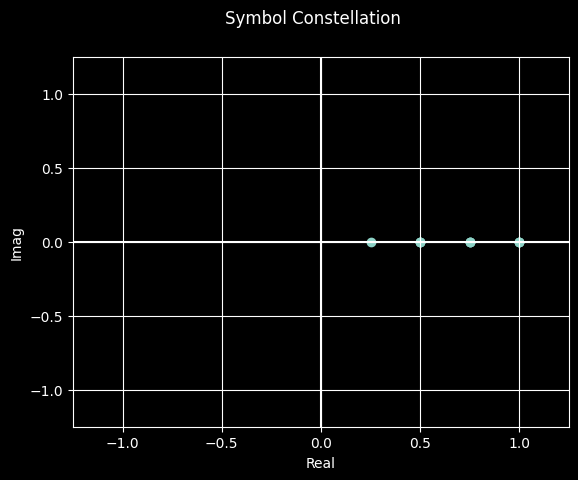

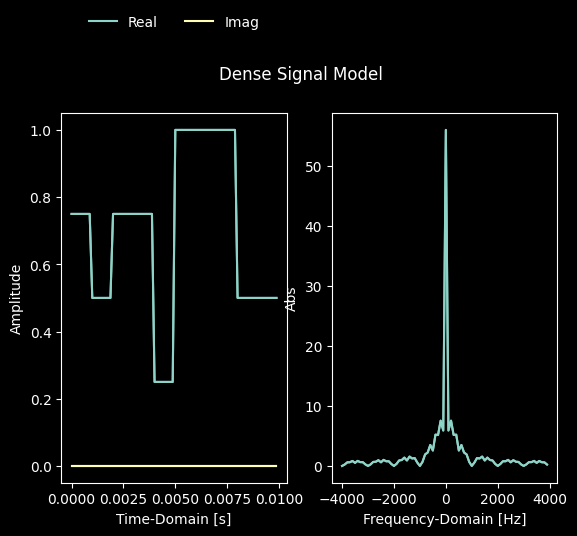

In [4]:
# Create pseudo-random number generator
rng = np.random.default_rng(42)

# Instantiante waveform
ask = AmplitudeShiftKeying(modulation_order=4)

# Generate a frame of data symbols from a set of random bits
data_bits = rng.integers(0, 2, ask.bits_per_frame(ask.num_data_symbols))
mapped_symbols = ask.map(data_bits)
_ = mapped_symbols.plot_constellation()

# Generate the base-band representation of a single communication frame
bandwidth, oversampling_factor = 1e3, 8
baseband_transmission = ask.modulate(ask.place(mapped_symbols), bandwidth, oversampling_factor)
_ = Signal.Create(baseband_transmission[None, :], bandwidth*oversampling_factor).plot()

plt.show()

We can now model the effects of hardware noise by adding a normally distributed noise signal to the baseband signal and observe the effects on the demodulated symbol constellation:

Transmitted data bits: [0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]
Received data bits: [0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]


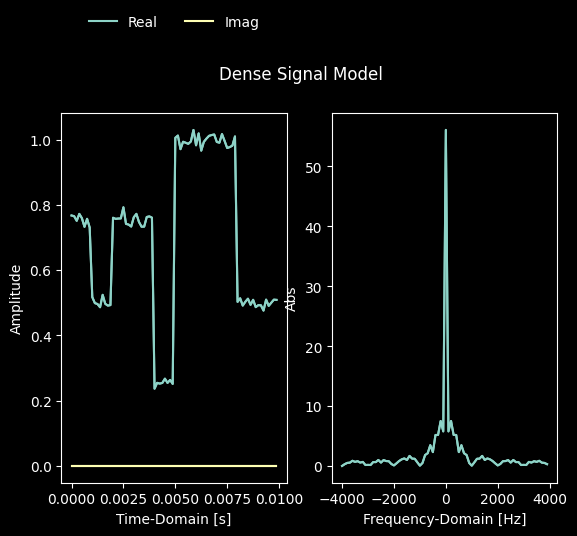

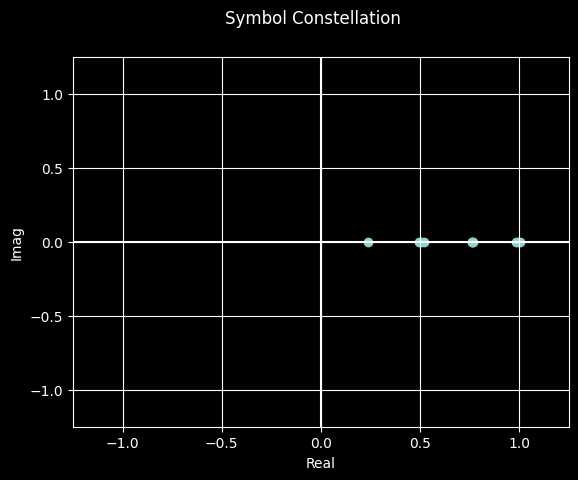

In [5]:
# Generate additive white gaussian noise
noise = rng.normal(0, .02, ask.samples_per_frame(bandwidth, oversampling_factor))

# Compute the baseband signal received over an AWGN channel
baseband_reception = baseband_transmission + noise
_ = Signal.Create(baseband_reception[None, :], bandwidth*oversampling_factor).plot()

# Demodulate the received signal
received_symbols = ask.demodulate(baseband_reception, bandwidth, oversampling_factor)
_ = received_symbols.plot_constellation()

bits = ask.unmap(received_symbols)
print(f'Transmitted data bits: {data_bits}')
print(f'Received data bits: {data_bits}')

plt.show()


Now, the newly added waveform is available to be configured to modems and used within the context of a simulation campaign:

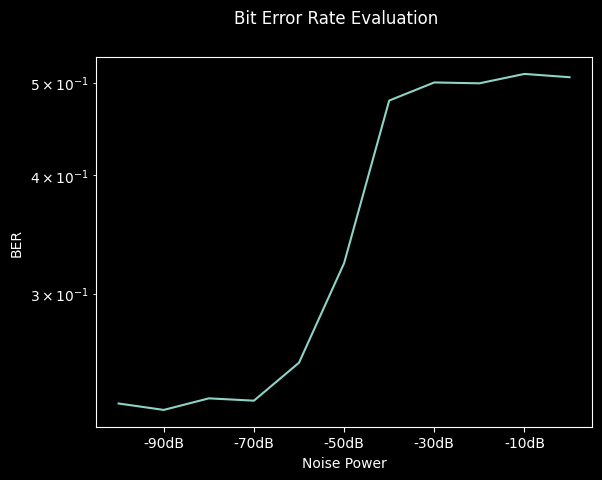

In [6]:
from hermespy.modem import BitErrorEvaluator, DuplexModem
from hermespy.simulation import Simulation

simulation = Simulation(console_mode=ConsoleMode.SILENT)
device = simulation.new_device(oversampling_factor=oversampling_factor, bandwidth=bandwidth)

modem = DuplexModem(waveform=ask)
device.add_dsp(modem)

simulation.new_dimension('noise_level', dB(range(-100, 10, 10)), device)
simulation.add_evaluator(BitErrorEvaluator(modem, modem))
simulation.num_samples = 10000
result = simulation.run()

_ = result.plot()
plt.show()